TODO:
- Try demeaning all series?
- Implement early stopping.
- Understand tensor dimensions throughout network.
- Why do plots have such different proportions of houses?
- Plot unseen days vs unseen homes.
- Look at LBM paper for error

In [1]:
from __future__ import division

from utils import *
from create_data import *
from build_models import *

import os
import pandas as pd
import numpy as np
from collections import OrderedDict
import time
from datetime import datetime
from datetime import date
from datetime import timedelta
from dateutil.parser import parse

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# from ggplot import *

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout
from keras import backend as K
from keras.layers import BatchNormalization

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
dir_proj = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis'
dir_data = os.path.join(dir_proj, 'data')
dir_for_model = os.path.join(dir_data, 'for_model')
dir_for_model_real = os.path.join(dir_for_model, 'real')
dir_for_model_synth = os.path.join(dir_for_model, 'synthetic')
dir_run = os.path.join(dir_proj, 'run', str(date.today()))

In [3]:
N_PER_DAY = 14400  # 24 * 60 * 60 / 6
HOUSE_IDS = range(1, 22); HOUSE_IDS.remove(14)  # no house 14
HOUSE_IDS_TEST = [2,9,20]
HOUSE_IDS_TRAIN_VAL = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_TEST]
# HOUSE_IDS_SOLAR = [3,11,21]  # according to paper
HOUSE_IDS_SOLAR = [1,11,21]  # according to inspection
HOUSE_IDS_NOT_SOLAR = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_SOLAR]
# TRAIN_VAL_DATE_MAX = date(2015,2,28)
APP_NAMES = ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']
TRAIN_DTS = np.load(os.path.join(dir_for_model, 'train_dts.npy'))

In [4]:
take_diff = False
val_prop = 0.2
train_dates = [dt.date() for dt in TRAIN_DTS]
extreme_percentile_cutoff = 98

In [5]:
# In every set of data, there's a feature set X, targets Y, and extra features
# regarding house number and date that can be used to subset or diagnose.
# This data will be saved as a package according to the order below. This makes
# it easier to enter into functions like train_test_split() and shuffle() using
# *kwargs.
X_idx = 0
Y_idx = 1
x_house_idx = 2
x_date_idx = 3

Run this once

In [6]:
# Process real data.
all_data = OrderedDict()
all_data['real'] = list(load_real_data(dir_for_model_real))
all_data['real'] = remove_extremes(all_data['real'], extreme_percentile_cutoff, Y_idx)
all_data = remove_solar_from_real(all_data, HOUSE_IDS_SOLAR, x_house_idx)
all_data = split_real_into_train_and_valtest(all_data, HOUSE_IDS_TRAIN_VAL, train_dates,
                                             x_house_idx, x_date_idx)
all_data = split_valtest_into_val_and_test(all_data, x_house_idx)

# Process synthetic data.
all_data['synth_train_all'] = list(load_synth_data(dir_for_model_synth))
all_data['synth_train_all'] = remove_extremes(all_data['synth_train_all'], extreme_percentile_cutoff, Y_idx)

# Create scalers.
scaler_real, scaler_synth, scaler_both = create_scalers_for_real_synth_both(all_data, X_idx)

# Scale validation and test data.
for split_type in ['val', 'test']:
    all_data[split_type][X_idx] = scaler_real.transform(all_data[split_type][X_idx])
    all_data[split_type][X_idx] = scaler_both.transform(all_data[split_type][X_idx])

obs for train/val: 4721 (70% of total)


/Users/sipola/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [7]:
# show_data_dims(all_data)

In [16]:
# Extract data for easy reference.
val_data = list(all_data['val'])
test_data = list(all_data['test'])

if take_diff:
    val_data[X_idx] = take_diff_df(val_data[X_idx])
    test_data[X_idx] = take_diff_df(test_data[X_idx])

In [17]:
scale_rows_separately = False

In [18]:
if scale_rows_separately:
    val_data[X_idx] = scale_rows_of_array(val_data[X_idx], True, False)
    test_data[X_idx] = scale_rows_of_array(test_data[X_idx], True, False)

In [9]:
# tmp = np.array([[1, 2, 4], [4, 5, 7]])
# print tmp
# tmp = scaler_real.transform(tmp)
# print tmp
# plt.close()
# for tmp1 in all_data['train'][0]:
#     plot_series(tmp1)
#     plt.show()

In [10]:
# plot_series(train_data[0][4])
# plt.show()
# plot_series(all_data['train'][0][4])
# plt.show()

In [19]:
# Get index of appliance to model.
app_names = ['fridge']
app_idx = []
for app_name in app_names:
    app_idx.append(APP_NAMES.index(app_name))

In [20]:
kernel_size = 6
strides = 2
start_filters = 8
pool_size = 2

input_shape = (N_PER_DAY, 1) if K.image_data_format() == 'channels_last' else (1, N_PER_DAY) # else is 'channels_first'

model = Sequential()
model.add(Conv1D(start_filters,
                 kernel_size,
                 strides=strides,
                 activation='relu',
                 input_shape=input_shape,
                 padding='same'))
model.add(MaxPooling1D(pool_size, padding='same'))
model.add(Conv1D(start_filters*2**1, kernel_size, strides=strides, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size, padding='same'))
# model.add(Conv1D(start_filters*2**2, kernel_size, strides=strides, activation='relu', padding='same'))
# model.add(MaxPooling1D(pool_size, padding='same'))
# model.add(Conv1D(start_filters*2**2, kernel_size, strides=strides, activation='relu', padding='same'))
# model.add(MaxPooling1D(pool_size, padding='same'))
# model.add(Conv1D(start_filters*2**3, kernel_size, strides=strides, activation='relu', padding='same'))
# model.add(MaxPooling1D(pool_size, padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
# model.add(BatchNormalization())
model.add(Dense(len(app_names), activation='softplus'))
model.compile(loss='mean_squared_error',
              # optimizer='adam',
              optimizer = keras.optimizers.Adam(lr=0.001),
              metrics=None)

In [21]:
# print train_data[0]

# total_chunks = 7

# tmp = 0
# for i in range(total_chunks):
#     chnk = get_chunk(train_data[0], i, total_chunks)
#     tmp += len(chnk)
#     print chnk
    
# print train_data[0]
# print train_data[0].shape[0], tmp

In [ ]:
# def data_provider():


In [22]:
def create_training_data(all_data, scaler_real, scaler_synth, scaler_both, X_idx, x_house_idx, only_train=None, random_state=None):
    '''
    Combine real and sampled synthetic training data.
    '''
    n_train_real = all_data['real_train'][0].shape[0] 

    # Randomly grab some of the synthetic data for training,
    # making sure it's the same size as the real data. Ignore
    # the rest of the split.
    all_data['synth_train'] = train_test_split(
        *all_data['synth_train_all'],
        train_size=n_train_real,
        stratify=all_data['synth_train_all'][x_house_idx],  # by house
        random_state=random_state)[::2]  # takes the first of the output pairs, which has same # obs as real train

    all_data['train'] = []
    for i, (r, s) in enumerate(zip(all_data['real_train'], all_data['synth_train'])):

        if i == X_idx:
            # Scale mean of real and synthetic series separately since levels of real is higher.
            r = scaler_real.transform(r)
            s = scaler_synth.transform(s)

        # Sort of for debugging only: want to see if just real or synth does better than real + synth.
        if only_train == 'synth':
            all_data['train'].append(s)
            continue
        if only_train == 'real':
            all_data['train'].append(r)
            continue

        all_data['train'].append(np.concatenate((r, s)))

    del all_data['synth_train']

    # Now scale combined real/synthetic power series by std.
    all_data['train'][X_idx] = scaler_both.transform(all_data['train'][X_idx])    

    # Mix up real and synth obs.
    all_data['train'] = shuffle(*all_data['train'], random_state=random_state)

    return all_data['train']

# def reshape_as_tensor(list_of_Xs):
#     '''
#     Reshape input 2D dataframe (shape = (obs, features)) as tensor.
#     '''
#     image_data_format = K.image_data_format()
#     assert image_data_format in ['channels_first', 'channels_last']
#     list_of_tensors = []
#     for X in list_of_Xs:
#         if image_data_format == 'channels_last':  # default on dev machine
#             X = X.reshape(X.shape[0], X.shape[1], 1)
#         else:
#             X = X.reshape(X.shape[0], 1, X.shape[1])
#         list_of_tensors.append(X)
#     return list_of_tensors

only_train = None
super_epochs = 3  # i.e., runs through data (incl. sample of synthetic)
sub_epochs_per_super = 4

# val_data = [np.random.randint(10, size=(20,3)), np.random.randint(10, size=(20,1))]  ############## DELETE

print '{} epochs in total'.format(super_epochs * sub_epochs_per_super)

e = 0
for meta_epoch in range(super_epochs):
    print 'creating training data for epochs {} to {}...'.format(e, e+sub_epochs_per_super-1)
    train_data = list(create_training_data(all_data, scaler_real, scaler_synth,
                                           scaler_both, X_idx, x_house_idx, only_train=only_train))
    if scale_rows_separately:
        # Can do this more elegantly when creating training data. Too expensive otherwise.
        train_data[X_idx] = scale_rows_of_array(train_data[X_idx], True, False)
        
    if take_diff:
        # Already did this for val and test.
        train_data[X_idx] = take_diff_df(train_data[X_idx])
        
    for sub_epoch in range(sub_epochs_per_super):
        
        print 'epoch {}'.format(e)
        
        # Get chunks of larger training set for this data.
        val_data_chunk = list(val_data)  # makes copy; just use all data for chunk
        train_data_chunk = []
        for dat in train_data:
            train_data_chunk.append(get_chunk(dat, sub_epoch, sub_epochs_per_super))
        
        # print train_data_chunk[1]
        
        # Reshape as tensor.
        train_data_chunk[X_idx] = reshape_as_tensor([train_data_chunk[X_idx]])
        val_data_chunk[X_idx] = reshape_as_tensor([val_data_chunk[X_idx]])

        history = model.fit(train_data_chunk[X_idx], train_data_chunk[Y_idx][:,app_idx],
                            validation_data=(val_data_chunk[X_idx], val_data_chunk[Y_idx][:,app_idx]),
                            epochs=1, batch_size=32)
        e += 1

12 epochs in total
creating training data for epochs 0 to 3...
epoch 0
Train on 2360 samples, validate on 1024 samples
Epoch 1/1
2360/2360 [==============================] - 12s - loss: 0.3146 - val_loss: 0.1820

['loss', 'val_loss']


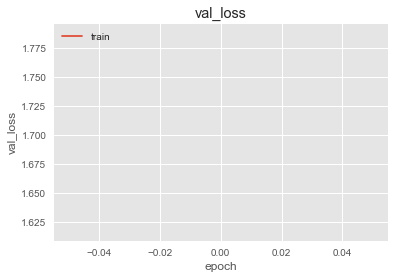

In [74]:
print(history.history.keys())
# summarize history for mse
plt.plot(history.history['val_loss'])
plt.title('val_loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
y_val = val_data[Y_idx][:,app_idx]
y_hat = model.predict(reshape_as_tensor([val_data[X_idx]]))
if all(y_hat[0] == y_hat):
    print 'all predicted values are the same!'

In [227]:
# plot_series(val_data[X_idx][1])

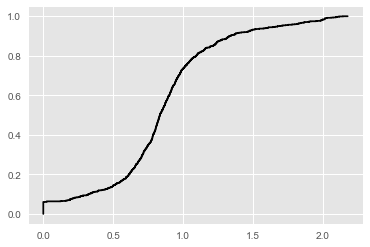

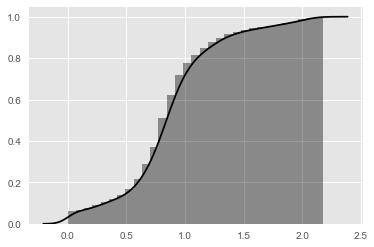

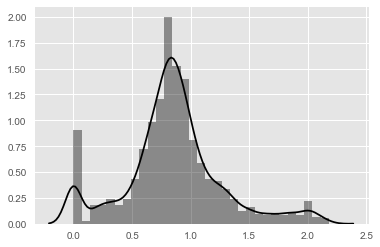

In [271]:
# sns.distplot(np.log2(y+1))
# sns.distplot(y, color='black')
plot_empir_cum(y_val)
plt.show()
sns.distplot(y_val, color='black', hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
plt.show()
sns.distplot(y_val, color='black')
plt.show()

# for i in range(Y.shape[1]):
#     ax = sns.distplot(Y[:,i], color='black')
#     ax.set_title('{}, actual'.format(APP_NAMES[i]))
#     plt.show()
#     ax = sns.distplot(Y_hat[:,i], color='black')
#     ax.set_title('{}, predicted'.format(APP_NAMES[i]))
#     plt.show() 

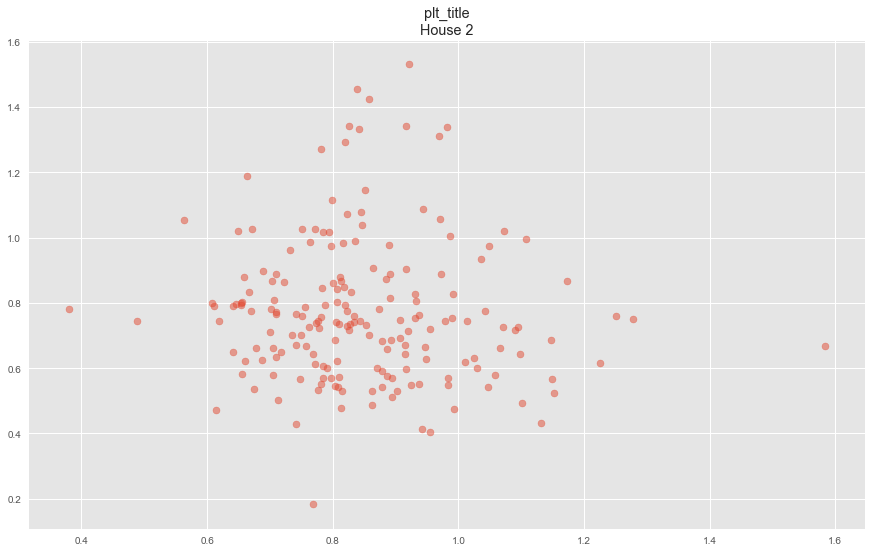

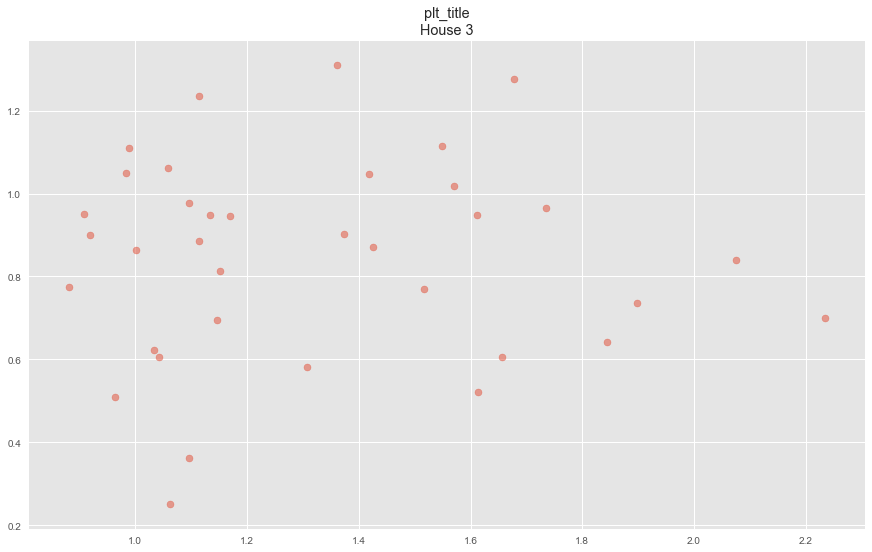

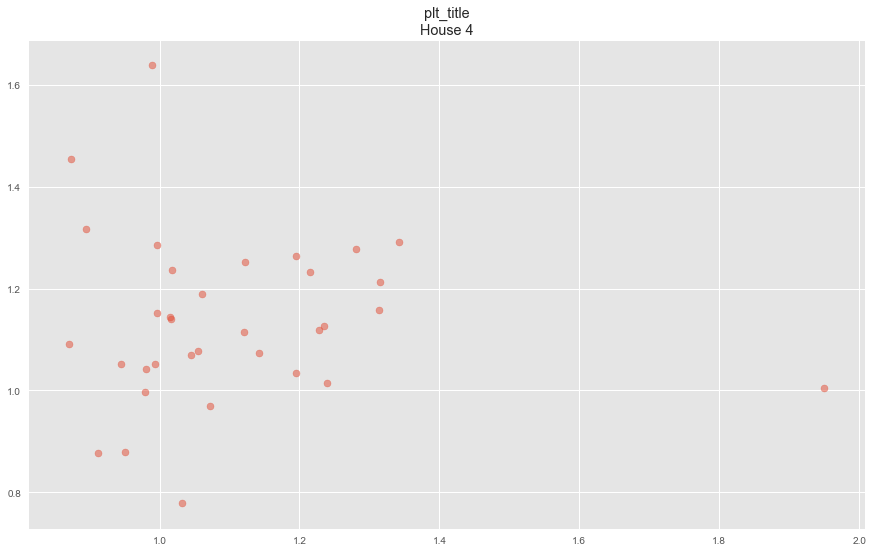

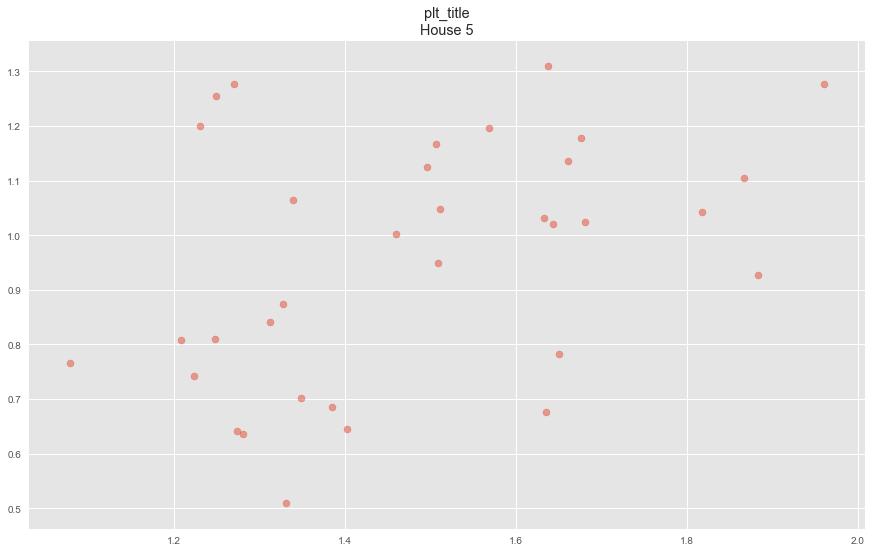

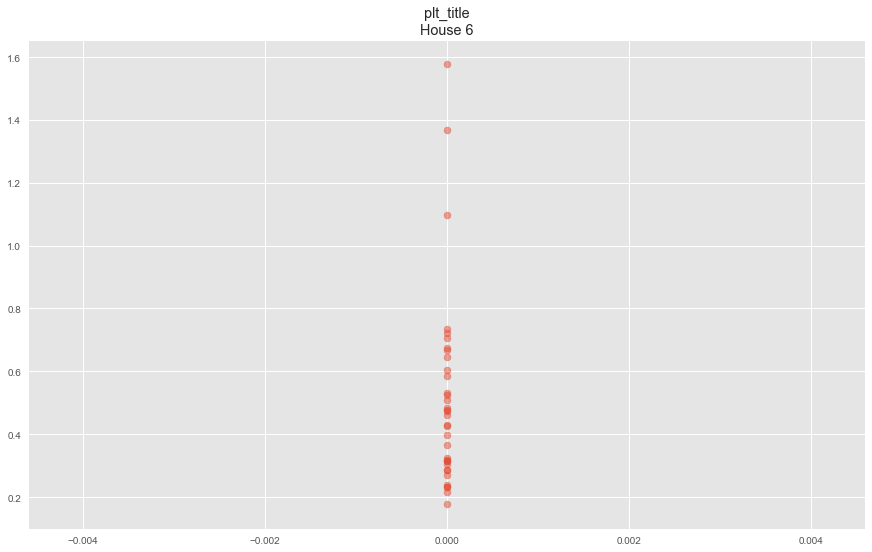

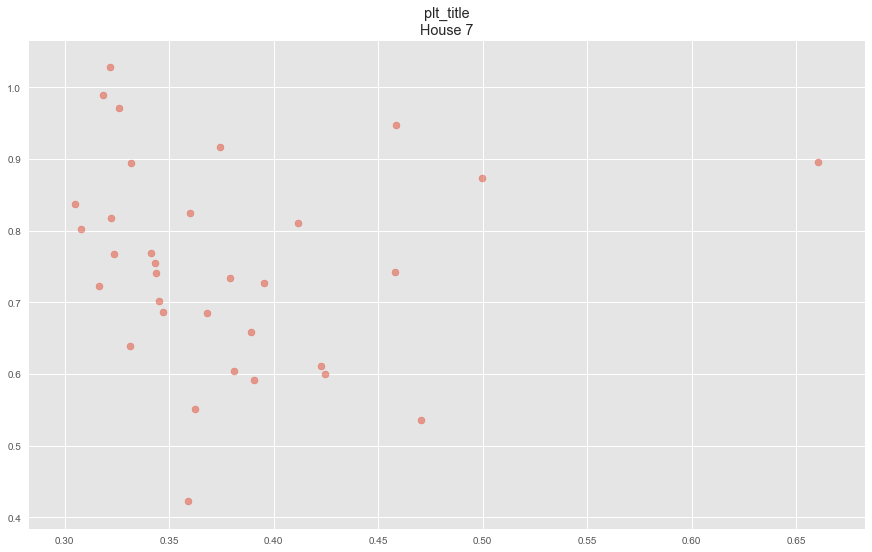

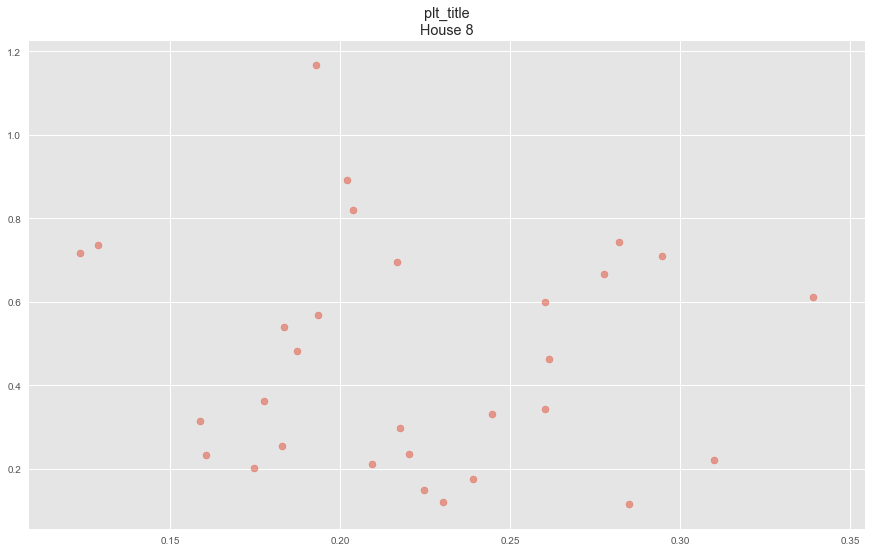

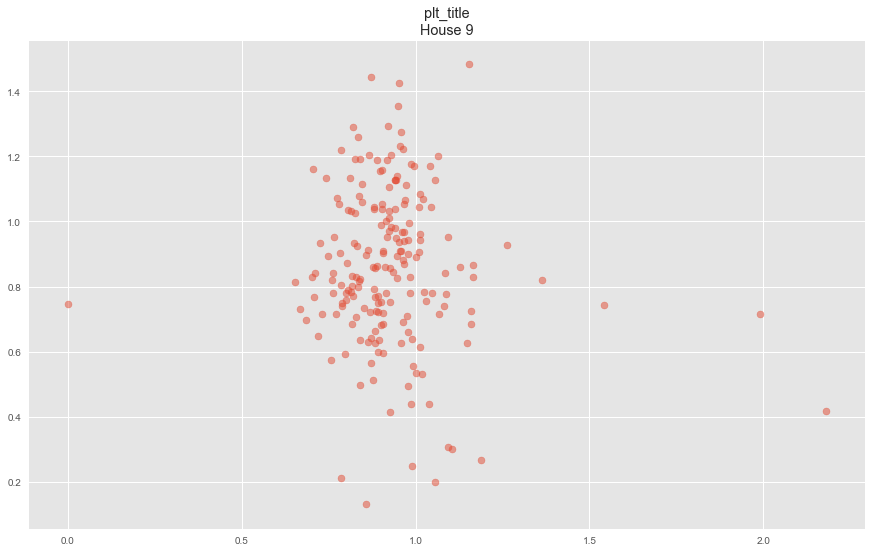

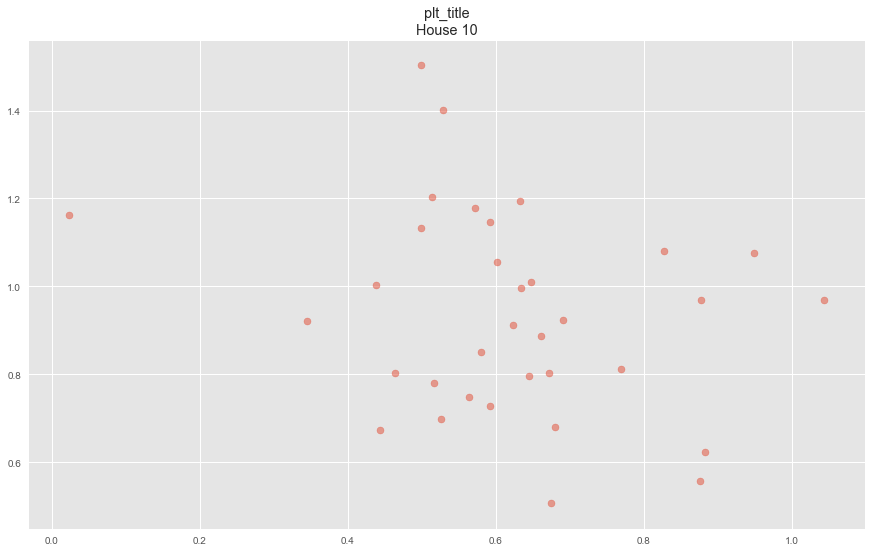

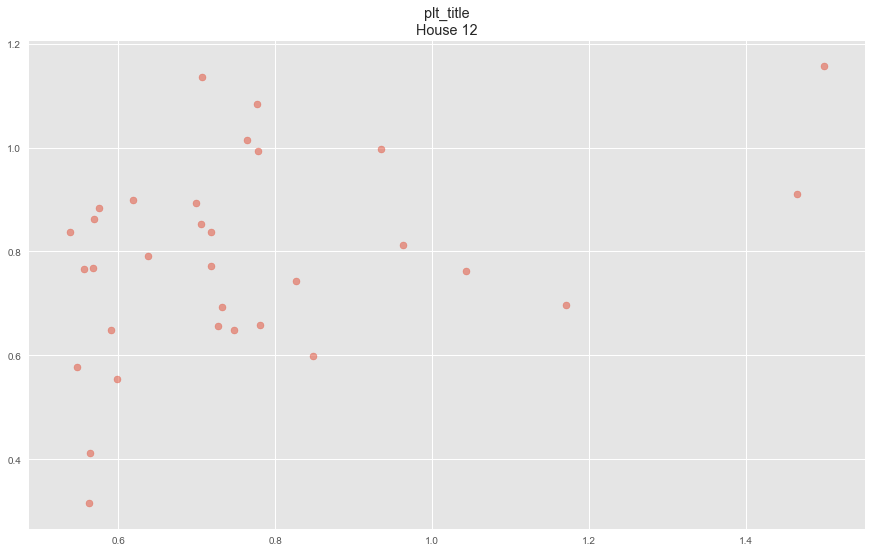

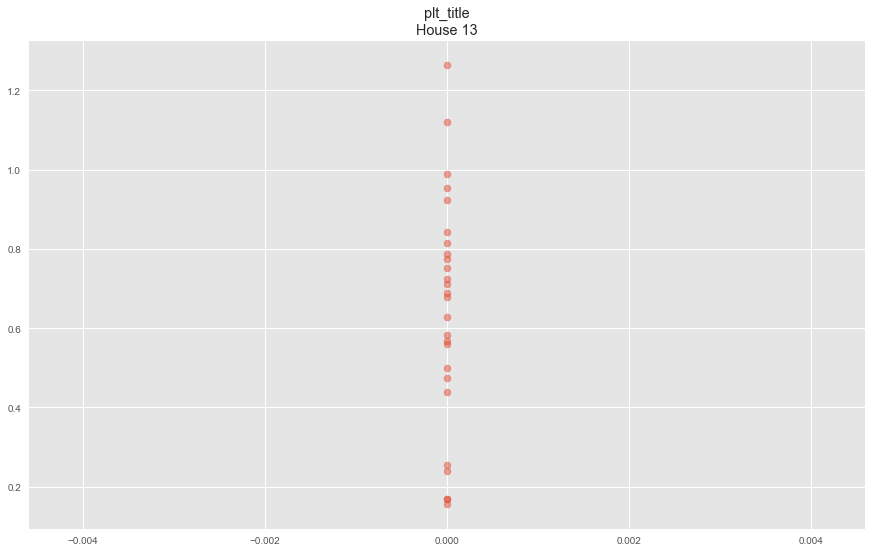

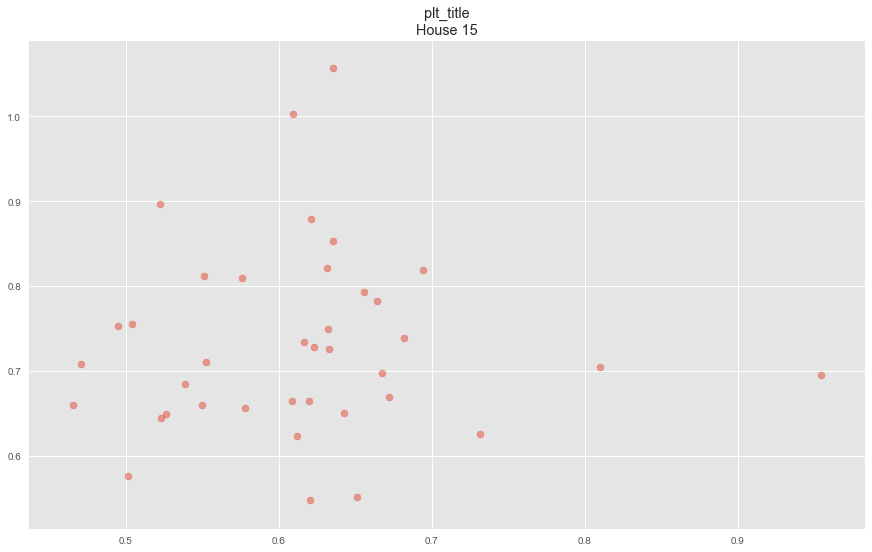

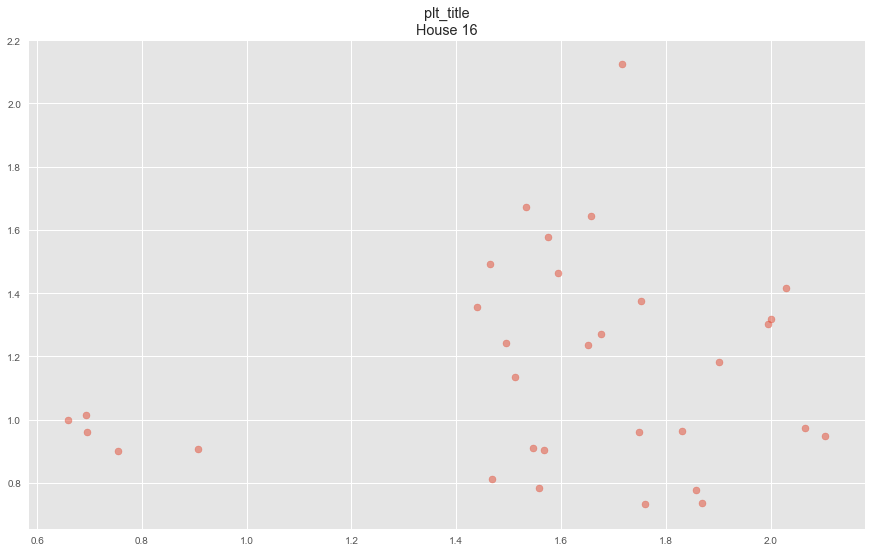

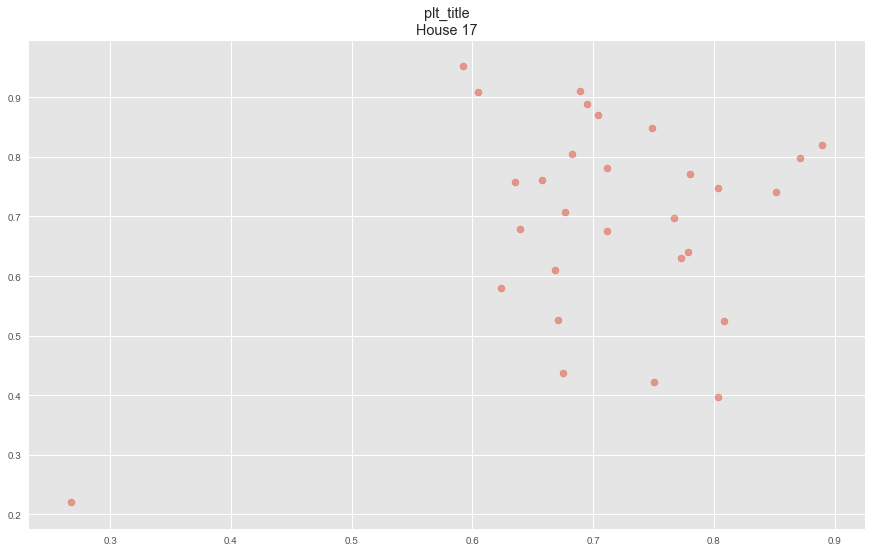

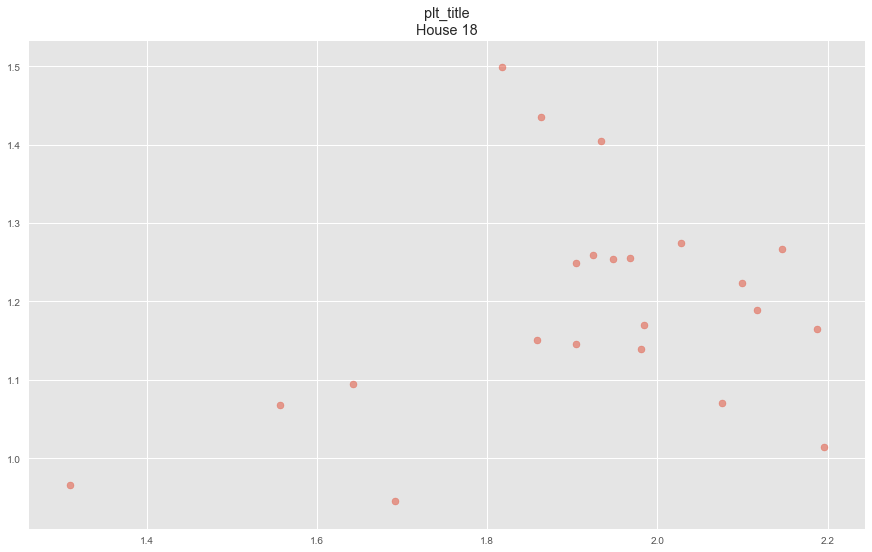

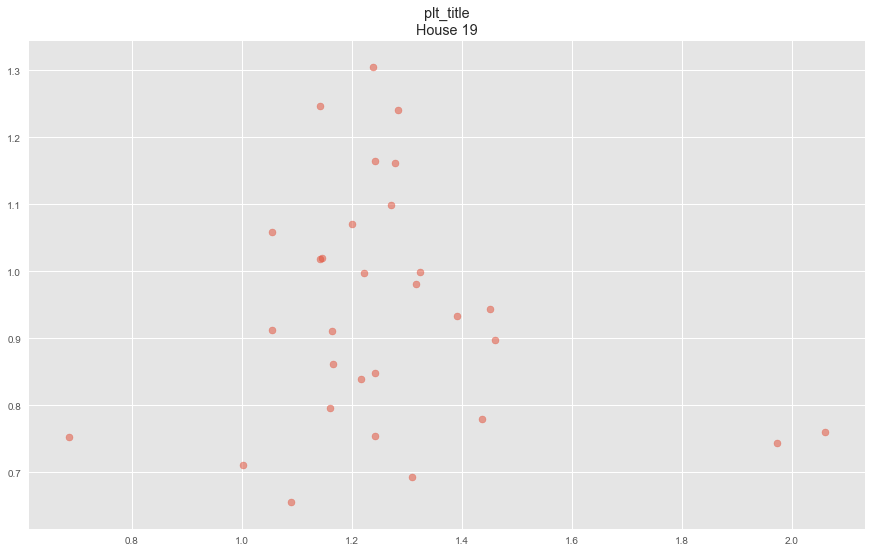

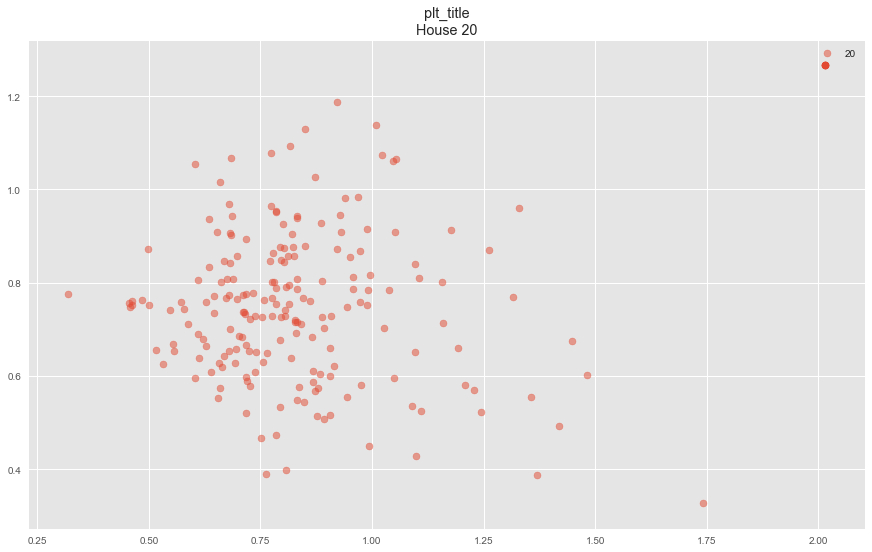

In [27]:
# # y_hat = dist_fun(y_hat, min_y, True)
# ax = sns.regplot(x=array_to_1d(y), y=array_to_1d(y_hat), color='black')
# ax.set_ylim(0,5)
# ax.set_xlim(0,5)

# colormap = plt.cm.Set1

x_house_val = val_data[x_house_idx]

plot_together = False
figsize = (15,9)
plt_title = 'plt_title'
if plot_together:
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, title=plt_title)
# ax.set_color_cycle([colormap(i) for i in np.linspace(0, 1, len(app_names))])
for house_id in list(set(x_house_val)):
    if not plot_together:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, title=plt_title + '\nHouse {}'.format(house_id))
    y_hat_house = y_hat[x_house_val==house_id]
    y_val_house = y_val[x_house_val==house_id]
    ax.scatter(y_val_house, y_hat_house, alpha=0.5, label=house_id)
# plt.show()
# ax.set_ylim(0,2)
# ax.set_xlim(0,5)
ax.legend()
plt.show()
# print min(y_hat)


# i = 3
# y, y_hat = Y[:,i], Y_hat[:,i]
# fig = plt.figure()
# ax = fig.add_subplot(111, title='Test scatter')
# ax.scatter(y_hat, y, color='black', alpha=0.5)
# ax.set_ylim(0,5)
# ax.set_xlim(0,5)
# # print min(y_hat)

num extreme predictions: 4
extreme prediction 0
actual energy: [ 0.395835], predicted: [ 11.80590725]


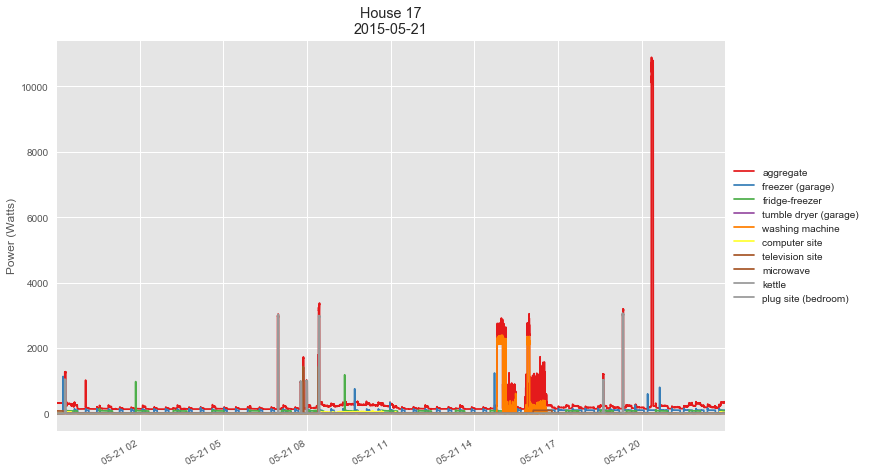

In [120]:
# Check where targets were normal but predictions were extreme.
extreme_y_hat_cutoff = 10

bad_idx = np.where(y_hat > extreme_y_hat_cutoff)[0]
print 'num extreme predictions: {}'.format(len(bad_idx))

i = 0  # change this
print 'extreme prediction {}'.format(i)

house_id = val_data[x_house_idx][bad_idx][i]
d = val_data[x_date_idx][bad_idx][i]
energy = val_data[Y_idx][:,app_idx][bad_idx][i]
print 'actual energy: {}, predicted: {}'.format(energy, y_hat[bad_idx][i])

plot_day(house_id, date_to_datetime(d), figsize=(15,8))

num extreme predictions: 2
extreme prediction 1
actual energy: [ 14.247415], predicted: [ 0.66881663]


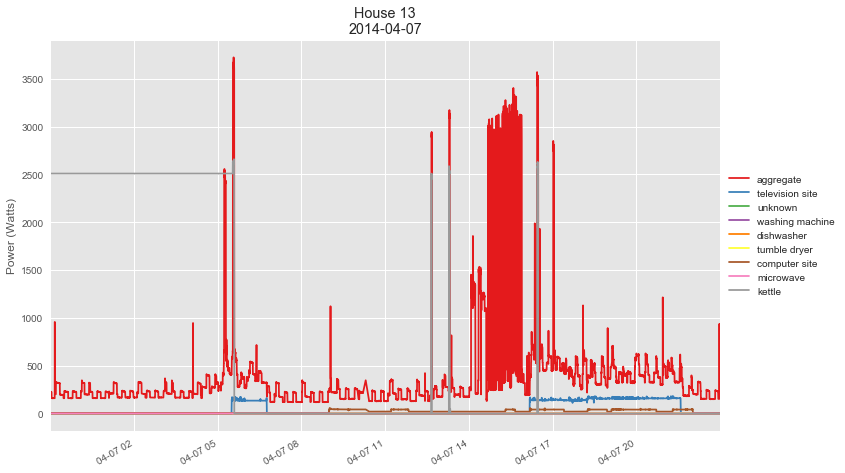

In [125]:
# Check where targets were extreme but predictions were too low.
extreme_y_cutoff = 2

bad_idx = np.where(y_val > extreme_y_cutoff)[0]
print 'num extreme predictions: {}'.format(len(bad_idx))

i = 1  # change this
print 'extreme prediction {}'.format(i)

house_id = val_data[x_house_idx][bad_idx][i]
d = val_data[x_date_idx][bad_idx][i]
energy = val_data[Y_idx][:,app_idx][bad_idx][i]
print 'actual energy: {}, predicted: {}'.format(energy, y_hat[bad_idx][i])

plot_day(house_id, date_to_datetime(d), figsize=(15,8))

In [ ]:
dir_refit_csv = os.path.join(dir_data, 'CLEAN_REFIT_081116')
dir_refit = os.path.join(dir_data, 'refit')
apps = pd.read_csv(os.path.join(dir_data, 'appliances.csv'))
app_dict = create_app_dict()
apps = apps_add_cols_from_patterns(apps, app_dict)
get_house_app_tuples, get_app_nums, get_app_name, is_a_target_app = create_app_funs(apps, app_dict, APP_NAMES)
load_app, load_ts, load_issues = create_load_funs(dir_refit)

path_daily_stats = os.path.join(dir_data, 'stats_by_day.pkl')
dstats = pd.read_pickle(path_daily_stats)
dstats = clean_daily_stats(dstats)

def get_df(house_id, use_app_names=False, dt_start=None, dt_end=None, include_issues=False):
    '''
    Plot time series of power data for each appliance, for specified house and date(time).
    '''
    
    # Load time series for house and get timestamps for specified date.
    ts_series = load_ts(house_id)
    
    # Add first column to df (timestamp).
    df = pd.DataFrame({'Unix': ts_series})
    
    # Add appliance columns.
    for app_num in range(10):
        if use_app_names:
            app_name = get_app_name(house_id, app_num)
        else:
            app_name = 'Appliance{}'.format(app_num) if app_num>0 else 'Aggregate'
        df[app_name] = load_app(house_id, app_num)
        
    if dt_start is not None:  # that is, if we don't want all dates
        ts_mask = get_ts_mask(ts_series, dt_start, dt_end)
        df = df.loc[ts_mask]
    
    if include_issues:
        # Add issues column.
        df['Issues'] = load_issues(house_id)
    
    return df


def plot_day(house_id, dt, savefile=None, figsize=(9,5), cols=None):
    '''
    Plot time series of power data for each appliance, for specified house and date(time).
    '''
    df = get_df(house_id, use_app_names=True, dt_start=dt)
    if cols is not None:
        cols += ['Unix']  # add Unix in case it wasn't included in cols
        cols = list(set(cols))
        df = df[cols]
    df['Time'] = pd.to_datetime(df['Unix'], unit='s', utc=True)
    df.set_index('Time', inplace=True)
    del df['Unix']
    
    # df = df.tz_localize('GMT').tz_convert('Europe/London')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    app_names = list(df)  # get columns from DataFrame
   
    # Set color map.
    colormap = plt.cm.Set1
    ax.set_color_cycle([colormap(i) for i in np.linspace(0, 1, len(app_names))])
    # ax = df.plot(figsize=figsize)
    for app_name in app_names:
        ax = df[app_name].plot(figsize=figsize)
    ax.set_title('House {}\n{}'.format(house_id, dt.date().strftime('%Y-%m-%d')))
    ax.set_xlabel('')
    ax.set_ylabel('Power (Watts)')
    # plt.xticks(np.arange(min(df.index), max(df.index)+1, 8.))

    # Put legend outside of plot.
    # https://stackoverflow.com/a/4701285/4794432
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # # Decrese legend font size.
    # fontP = FontProperties()
    # fontP.set_size('xx-small')

    if savefile is not None:
        plt.savefig(savefile)
    return ax

In [ ]:
# val_data[X_idx][0]
i = 21
app_name = 'washing machine'

app_idx = APP_NAMES.index(app_name)

plot_series(val_data[X_idx][i])
house_id = val_data[x_house_idx][i]
d = val_data[x_date_idx][i]
energy1 = val_data[Y_idx][i][app_idx]
print house_id, d, energy1

plot_day(house_id, date_to_datetime(d))
energy2 = get_energy(dstats, house_id, d, get_app_nums(house_id, app_name))
print energy2